# Model project: A Solow-Swan model with endogenous growth 

Imports and set magics:

In [26]:
import numpy as np
from scipy import optimize
import sympy as sm
from IPython.display import display
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

The following model is the Solow-Swan model extended to include semi-endogenous growth of technology. In steady-state the level of GDP per worker is highly dependent on the growth of technology, and therefore it is interesting to examine the case of endogenous growth. 

*The four equations of the model are:* 

$Y_t = K_t^\alpha (A_t L_t)^{1-\alpha}$
 
$A_t=K_t^\phi , \phi<1$

$K_{t+1}=sY_t+(1-\delta)K_t$

$L_{t+1}=(1+n)L_t$


$Y_t$ is output, $K_t$ is capital, $A_t$ is technology and $L_t$ is the labor force. These are the variables of the model. The parameters are $\alpha, \phi, s, \delta, n$, where $\alpha$ is the output elasticity of capital and labor, $\phi$ is the return from capital to the technological level, $\delta$ is the depreciation of capital, n is the growth of labor. s is the savings which is equal to investments, since it is a closed economy. 

## Analytical solution

To solve the model we have to find the steady state value for k and y. We need to define the model in terms of effective labor units. By doing so and substituting technology and labor into the production function and capital accumulation function our model consists of two equations. Lower case letters implies a variable in terms of effective labor units.

In [27]:
# Variables and parameters defined to be shown in equations

alpha = sm.symbols("alpha")
phi = sm.symbols("phi")
delta = sm.symbols("delta")
s = sm.symbols("s")
n = sm.symbols("n")
ke = sm.symbols("k_t")
ke1 = sm.symbols("k_t+1")
ye = sm.symbols("y_t")
kss = sm.symbols("k^*")
yss = sm.symbols("y^*")

# Equations defined in effective labor units

Production = sm.Eq(ye, ke**alpha)
Capitalacc = sm.Eq(ke1/ke, (1/(1+n))*(s*ye/ke+(1-delta))**(1-phi))

display(Production)
display(Capitalacc)

Eq(y_t, k_t**alpha)

Eq(k_t+1/k_t, (-delta + 1 + s*y_t/k_t)**(1 - phi)/(n + 1))

We use SymPy to calculate the steady state values for y and k by substituting the steady state value for k and y into their respectively variables with time subscripts. We can then solve for the steady state value of k by using the solve function. To find the steady state value of y we substitute the steady state value of k into the production function.

In [28]:
Calc = Capitalacc.subs(ye, Production.rhs)
Transition = sm.Eq(Calc.lhs * ke, Calc.rhs * ke)
sst = sm.Eq(kss, ke)
sst1 = sm.Eq(kss, ke1)
ysst = sm.Eq(yss, ye)

Transition_ss = Transition.subs({ke: sst.lhs, ke1: sst1.lhs})
Productione_ss = Production.subs({ye: ysst.lhs, ke: sst.lhs})

k_sssolve = sm.solve(Transition_ss, kss)
y_ss = Productione_ss.subs(kss, k_sssolve[0])
k_ss = sm.Eq(kss, k_sssolve[0])

display(k_ss)
display(y_ss)

Eq(k^*, ((delta - 1 + (n + 1)**(-1/(phi - 1)))/s)**(1/(alpha - 1)))

Eq(y^*, (((delta - 1 + (n + 1)**(-1/(phi - 1)))/s)**(1/(alpha - 1)))**alpha)

We want to find a value for k and y in the steady state and to do that we define the steady state equations as functions and thereafter we use parametervalues to find a value.

In [29]:
k_ss_func = sm.lambdify(args=(s,alpha,delta,phi,n),expr=k_sssolve[0])
y_ss_func = sm.lambdify(args=(s,alpha,delta,phi,n),expr=y_ss.rhs)

# The parameter values are defined as follows
s_val = 0.101
alpha_val = 0.33
delta_val = 0.05
phi_val = 0.5
n_val = 0.02

solk = k_ss_func(s_val,alpha_val,delta_val,phi_val,n_val)
soly = y_ss_func(s_val,alpha_val,delta_val,phi_val,n_val)

print(f"The steady state value of capital is {solk:.2f}")
print(f"The steady state value of output is {soly:.2f}")

The steady state value of capital is 1.18
The steady state value of output is 1.06


## Numerical solution

In [30]:
# Define the function for which we want to find the roots
def f(k):
    return k - k/(1+n_val) * (s_val * k**(alpha_val - 1) + 1 - delta_val)**(1 - phi_val)

# Find the root of the function
k = brentq(f, 0.01, 100)

y = k**alpha_val

# Now, k is the solution to the equation
print(f"The steady state value of capital is {k:.2f}")
print(f"The steady state value of output is {y:.2f}")

The steady state value of capital is 1.18
The steady state value of output is 1.06


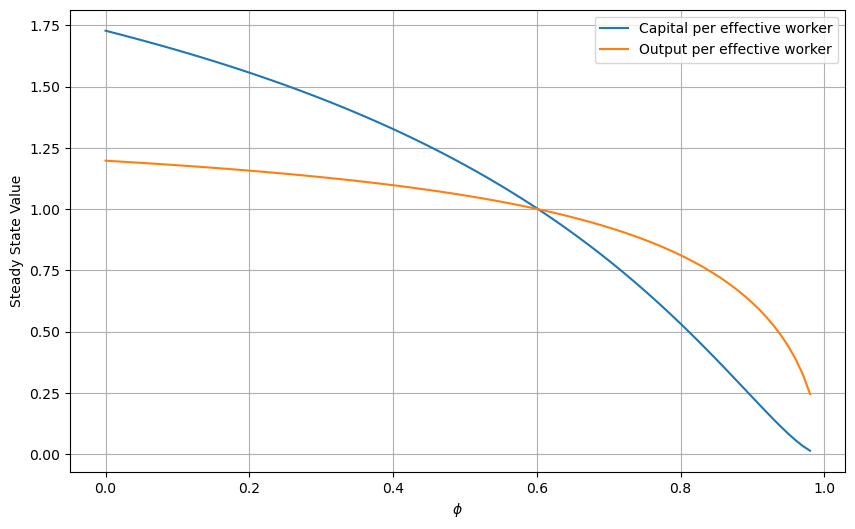

In [31]:
phi_vec = np.arange(0, 0.99, 0.01)

# Define the function for which we want to find the roots
def f(k_phi, phi_val):
    return k_phi - k_phi/(1+n_val) * (s_val * k_phi**(alpha_val - 1) + 1 - delta_val)**(1 - phi_val)

# Lists to store the values of k_phi and y_phi
k_values = []
y_values = []

# Loop over different values of phi_val
for phi_val in phi_vec:
    # Find the root of the function
    k_phi = brentq(f, 0.01, 100, args=(phi_val,))
    y_phi = k_phi**alpha_val
    # Append the values to the lists
    k_values.append(k_phi)
    y_values.append(y_phi)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(phi_vec, k_values, label='Capital per effective worker')
plt.plot(phi_vec, y_values, label='Output per effective worker')
plt.xlabel('$\phi$')
plt.ylabel('Steady State Value')
plt.legend()
plt.grid(True)
plt.show()

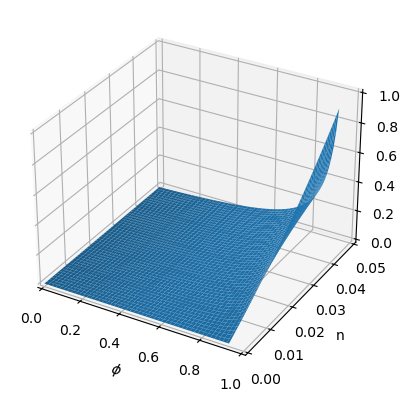

In [32]:
phi_vec_res = np.arange(0, 0.94, 0.01)
n_vec = np.arange(0, 0.050, 0.001)

# Create a meshgrid for phi and n
phi_mesh, n_mesh = np.meshgrid(phi_vec_res, n_vec)

# Compute g for each pair of phi and n
g_mesh = (1 + n_mesh)**(phi_mesh / (1 - phi_mesh)) - 1

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot g as a function of phi and n
ax.plot_surface(phi_mesh, n_mesh, g_mesh)

ax.set_ylim(0, 0.05)
ax.set_xlim(0, 1)
ax.set_zlim(0, 1)

ax.set_xlabel('$\phi$')
ax.set_ylabel('n')
ax.set_zlabel('g')

plt.show()

# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

# Conclusion

Add concise conclusion. 